## Mathsolve - Photomath demo project

The goal of this project is to make a model which would be able to detect handwritten math symbols on a picture. After detecting math symbols the app should be able to solve simple mathematical problem given on a picture (addition, subtraction, multiplication and divison).

### Dataset preprocessing

In [1]:
# import useful libraries
import cv2 as cv
import numpy as np
import pandas as pd
import os
import PIL
import pathlib
import matplotlib.pyplot as plt

In [2]:
# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Let's try to see how many images of each class do we have at our disposal.

In [42]:
# path to the main dataset directory
dataset_main_path = r"C:\Users\Korisnik\git_workspace\MathSolve\dataset"

In [37]:
# list of classes present in the dataset
dataset_classes = os.listdir(dataset_main_path)

print('Number of classes: ', len(dataset_classes))
print('List of classes:')
print(dataset_classes)

Number of classes:  19
List of classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub', 'x', 'y', 'z']


Now, let's try to see have many images each class consists of, and check if we have significant imbalance in the dataset.

In [38]:
# dictionary which will contain images count of each class
class_img_count = {}

# total number of images
total_img_count = 0

# loop through classes and count number of images
for item in dataset_classes:
    current_class_path = dataset_main_path + '\\' + item
    current_class_img_count = len(os.listdir(current_class_path))
    class_img_count[item] = current_class_img_count
    
# print class image count for inspection
for dataset_class in class_img_count:
    print(dataset_class, ':', class_img_count[dataset_class])
    
# mean value of images per class
for dataset_class in class_img_count:
    total_img_count += class_img_count[dataset_class]
    
img_per_class_mean = int(total_img_count/len(dataset_classes))
    
print('Mean value of images per class: ', img_per_class_mean)

0 : 596
1 : 562
2 : 433
3 : 541
4 : 526
5 : 433
6 : 581
7 : 533
8 : 554
9 : 547
add : 596
dec : 624
div : 618
eq : 634
mul : 577
sub : 655
x : 452
y : 399
z : 212
Mean value of images per class:  530


From the output above it can be seen that majority of classes are well represented. Mean value of images per class is 530. Taking that into account we will try to handle classes that are under-sampled (classes which have less than 500 images). This will be done by augmentation and over-sampling of minority classes. Most problematic are classes 'y' and 'z'.  

In [39]:
# set threshold for data augmentation at 500 
threshold = 500

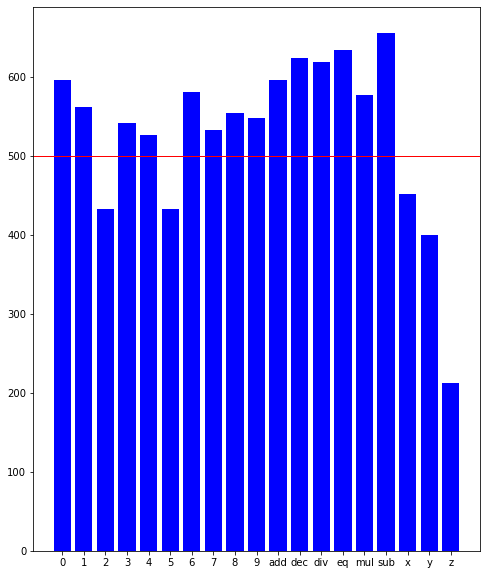

In [40]:
# visualize dataset distribution
plt.figure(figsize=(8,10))

plt.bar(list(class_img_count.keys()), class_img_count.values(), color='b')
plt.axhline(y=threshold,linewidth=1, color='r')
plt.show()

Now, let's write a function that will check image file types. It will count how many pictures of each class are PNG and JPG. Ultimately, we want to work with JPG so we will convert all PNGs to JPGs.

In [41]:
def count_JPG_PNG(path):
    """This function counts how many PNG and JPG formatted pictures there are
    in the each class of the dataset.
    
    Args:
        path (str): Root path of the dataset directory.
    Returns:
        dict: Nested dictionary with PNGs and JPGs counts.
    """
    
    jpg_png_count_dict = {}
    
    dataset_dir = pathlib.Path(path)
    classes_subdir = [x for x in dataset_dir.iterdir() if x.is_dir()]
    
    for subdir in classes_subdir:
        temp = {}
        jpg_count = len(list(subdir.glob('**/*.jpg')))
        png_count = len(list(subdir.glob('**/*.png')))
        
        temp['jpg'] = jpg_count
        temp['png'] = png_count
        
        jpg_png_count_dict[str(subdir).split('\\')[-1]] = temp
        
    return jpg_png_count_dict

In [42]:
counted_image_format_types = count_JPG_PNG(dataset_main_path)

In [43]:
counted_image_format_types

{'0': {'jpg': 470, 'png': 126},
 '1': {'jpg': 487, 'png': 75},
 '2': {'jpg': 344, 'png': 89},
 '3': {'jpg': 414, 'png': 127},
 '4': {'jpg': 466, 'png': 60},
 '5': {'jpg': 269, 'png': 164},
 '6': {'jpg': 425, 'png': 156},
 '7': {'jpg': 465, 'png': 68},
 '8': {'jpg': 420, 'png': 134},
 '9': {'jpg': 374, 'png': 172},
 'add': {'jpg': 567, 'png': 29},
 'dec': {'jpg': 624, 'png': 0},
 'div': {'jpg': 557, 'png': 61},
 'eq': {'jpg': 630, 'png': 4},
 'mul': {'jpg': 567, 'png': 10},
 'sub': {'jpg': 625, 'png': 30},
 'x': {'jpg': 0, 'png': 452},
 'y': {'jpg': 0, 'png': 399},
 'z': {'jpg': 0, 'png': 212}}

<AxesSubplot:>

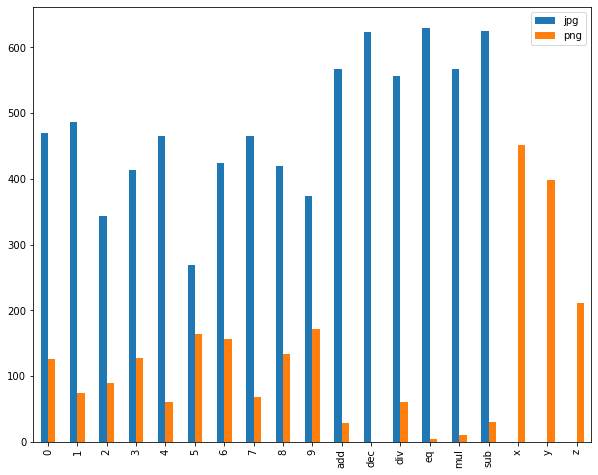

In [44]:
# visualize image format types distribution accross classes
df_from_dict = pd.DataFrame(counted_image_format_types)

df_from_dict.transpose().plot.bar(figsize = (10, 8))

Let's write a function that will convert PNG images to JPG, and delete all PNG images so that we are left only with JPGs.

In [45]:
def convert_to_JPG(path):
    """This function converts all PNG images found in subdirectories of root directory to JPG image. Then it deletes all
    PNG images so only JPG images are left in subdirectories.
    
    Args:
        path (str): Root path of the dataset directory.
    """
    
    dataset_dir = pathlib.Path(path)
    png_list = list(dataset_dir.glob('**/*.png'))
    
    for png in png_list:
        png_image = PIL.Image.open(png)
        # convert RGBA (red-blue-green-alpha) to RGB (red-blue-green) => alpha means transparency
        # we have to discard alpha channel to be able to save JPG
        rgb_im = png_image.convert('RGB')
        # path to save JPG image 
        save_path = str(png)[:-3]+'jpg'
        # save as JPG to aboove save_path
        rgb_im.save(save_path)
        # remove processed png image 
        os.remove(png)

In [46]:
# convert PNGs to JPG format
convert_to_JPG(dataset_main_path)

In [47]:
# count image format types after conversion
counted_image_format_types_after = count_JPG_PNG(dataset_main_path)

In [48]:
counted_image_format_types_after

{'0': {'jpg': 595, 'png': 0},
 '1': {'jpg': 562, 'png': 0},
 '2': {'jpg': 433, 'png': 0},
 '3': {'jpg': 541, 'png': 0},
 '4': {'jpg': 526, 'png': 0},
 '5': {'jpg': 433, 'png': 0},
 '6': {'jpg': 581, 'png': 0},
 '7': {'jpg': 533, 'png': 0},
 '8': {'jpg': 554, 'png': 0},
 '9': {'jpg': 546, 'png': 0},
 'add': {'jpg': 596, 'png': 0},
 'dec': {'jpg': 624, 'png': 0},
 'div': {'jpg': 618, 'png': 0},
 'eq': {'jpg': 634, 'png': 0},
 'mul': {'jpg': 577, 'png': 0},
 'sub': {'jpg': 655, 'png': 0},
 'x': {'jpg': 452, 'png': 0},
 'y': {'jpg': 399, 'png': 0},
 'z': {'jpg': 212, 'png': 0}}

<AxesSubplot:>

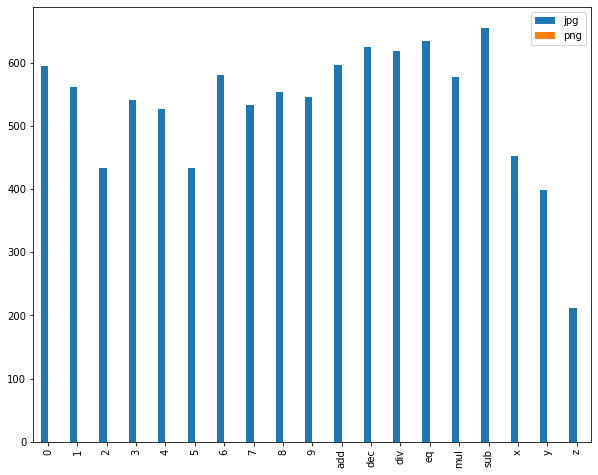

In [49]:
# visualize image format types distribution accross classes after conversion
df_from_dict_after = pd.DataFrame(counted_image_format_types_after)

df_from_dict_after.transpose().plot.bar(figsize = (10, 8))

Great, now we have consistent image format types to work with. Next, we will use data augmentation technique to handle classes with low number of image samples. The purpose of this is to get balanced classes in our dataset.

### Data augmentation 

In [4]:
# for data augmentation using python and Keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

We'll write a function that will be doing data augmentation for undersampled classes.

In [47]:
def augment_images(dataset_class, image, batch_size):
    """This function augments desired number of images to selected dataset class using ImageDataGenerator from keras.
    Args:
        dataset_class (str): dataset class to generate augmented images for.
        image (str): Name and format type of the exact image from which to generate augmented images eg. "image_name.jpg"
        batch_size (int): Number of images to be generated.
    """
    dataset_path = r"C:\Users\Korisnik\git_workspace\MathSolve\dataset"
    save_prefix = "keras_genrated"
    
    # assembled path for directory where images will be generated with keras
    generated_images_dir_path = dataset_path + "\\" + dataset_class
    
    #print("Checking for directory...")
    #if not os.path.isdir(generated_images_dir_path):
        #print("Directory not found!")
    
    datagen = ImageDataGenerator(rotation_range = 25,
                                 width_shift_range = 0.3,
                                 height_shift_range = 0.3,
                                 shear_range = 0.3,
                                 zoom_range = 0.3,
                                 horizontal_flip = False, 
                                 fill_mode = 'nearest')
    
    img = load_img(dataset_path + "\\" + dataset_class + "\\" + image)  # this is a PIL image
    #print("Image loaded!")
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(x, 
                              batch_size = 1,
                              save_to_dir = generated_images_dir_path, 
                              save_prefix = save_prefix, 
                              save_format = 'jpg'):
        i += 1
        if i > batch_size:
            break  # otherwise the generator would loop indefinitely

In [48]:
# generate augmented images for class "2" from image "2gzFqiCT.jpg"
augment_images("2", "2gzFqiCT.jpg", 100)

# generate augmented images for class "5" from image "0mKkrJd4.jpg"
augment_images("5", "0mKkrJd4.jpg", 100)

# generate augmented images for class "x" from image "eJjI3qC4.jpg"
augment_images("x", "eJjI3qC4.jpg", 100)

# generate augmented images for class "y" from image "xSeBvYdF.jpg"
augment_images("y", "xSeBvYdF.jpg", 150)

# generate augmented images for class "z" from image "0GaQrphn.jpg"
augment_images("z", "0GaQrphn.jpg", 350)

In [49]:
# count image format types after augmentation 
counted_image_format_types_after_aug = count_JPG_PNG(dataset_main_path)

In [50]:
counted_image_format_types_after_aug

{'0': {'jpg': 595, 'png': 0},
 '1': {'jpg': 562, 'png': 0},
 '2': {'jpg': 534, 'png': 0},
 '3': {'jpg': 541, 'png': 0},
 '4': {'jpg': 526, 'png': 0},
 '5': {'jpg': 530, 'png': 0},
 '6': {'jpg': 581, 'png': 0},
 '7': {'jpg': 533, 'png': 0},
 '8': {'jpg': 554, 'png': 0},
 '9': {'jpg': 546, 'png': 0},
 'add': {'jpg': 596, 'png': 0},
 'dec': {'jpg': 624, 'png': 0},
 'div': {'jpg': 618, 'png': 0},
 'eq': {'jpg': 634, 'png': 0},
 'mul': {'jpg': 577, 'png': 0},
 'sub': {'jpg': 655, 'png': 0},
 'x': {'jpg': 550, 'png': 0},
 'y': {'jpg': 550, 'png': 0},
 'z': {'jpg': 556, 'png': 0}}

<AxesSubplot:>

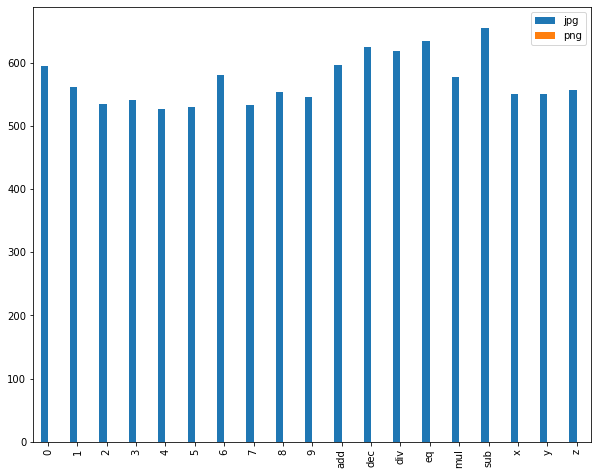

In [52]:
# visualize image format types distribution accross classes after augmentation
df_from_dict_after_aug = pd.DataFrame(counted_image_format_types_after_aug)

df_from_dict_after_aug.transpose().plot.bar(figsize = (10, 8))

Great, now we have much more balanced dataset.